In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
from tqdm import tqdm
import yaml

import torch
import torch.nn.functional as F
from torch import tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

sys.path.append('../../src')
from common import common, transform, json
from common.json import IA_FORMAT, START_IDX
from common.functions import gauss, cos_similarity, standardize
from common.keypoint import body
from common.default import PASSING_DEFAULT
from common.video import Capture
from display.display import display
from individual_activity.individual_activity import IndividualActivity

In [2]:
device_idx = 0
device = f'cuda:{device_idx}' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Indivisual Activity をロード

In [3]:
data_settings = [
    {'room_num': '02', 'date': '20210903', 'option': 'passing'},
    {'room_num': '02', 'date': '20210903', 'option': 'attention'},
    {'room_num': '08', 'date': '20210915', 'option': 'passing'},
    {'room_num': '08', 'date': '20210915', 'option': 'attention'},
    {'room_num': '09', 'date': '20210706', 'option': 'passing'},
    {'room_num': '09', 'date': '20210706', 'option': 'attention'}
]

In [4]:
def get_homo(room_num):
    field_path = os.path.join(common.data_dir, '{}/field.png'.format(room_num))
    field_raw = cv2.imread(field_path)
    p_video = transform.homo[room_num][0]
    p_field = transform.homo[room_num][1]
    homo = transform.Homography(p_video, p_field, field_raw.shape)
    return homo

In [5]:
def load_individuals(json_data, prefix, homo):
    individuals = {}
    for data in json_data:
        label = prefix + str(data[IA_FORMAT[0]])
        frame_num = data[IA_FORMAT[1]]
        tracking_point = data[IA_FORMAT[2]]
        keypoints = data[IA_FORMAT[3]]

        if label not in individuals:
            ia = IndividualActivity(label, homo)
            individuals[label] = ia
        else:
            ia = individuals[label]

        ia.tracking_points[frame_num] = tracking_point
        ia.keypoints[frame_num] = keypoints
        for f in IA_FORMAT[START_IDX:]:
            ia.indicator_dict[f][frame_num] = data[f]
            
    return individuals

In [6]:
individuals = {}
for setting in data_settings:
    print(setting)
    room_num = setting['room_num']
    date = setting['date']
    opt = setting['option']
    
    homo = get_homo(room_num)
    
    if opt is None:
        dir_path = f'{common.data_dir}/{room_num}/{date}/*'
    else:
        dir_path = f'{common.data_dir}/{room_num}/{date}/{opt}/*'
    dirs = glob.glob(dir_path)
    dirs = sorted(dirs)[:-1]  # delete make_csv.csv
    
    for path in tqdm(dirs):
        path = f'{path}/json/individual_activity.json'
        json_data = json.load(path)
        prefix = common.split_path(path)[-6] + '_' + common.split_path(path)[-3] + '_'  # room-num_date_
        individuals.update(load_individuals(json_data, prefix, homo))

{'room_num': '02', 'date': '20210903', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 14.14it/s]


{'room_num': '02', 'date': '20210903', 'option': 'attention'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02it/s]


{'room_num': '08', 'date': '20210915', 'option': 'passing'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 22.74it/s]


{'room_num': '08', 'date': '20210915', 'option': 'attention'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.73s/it]


{'room_num': '09', 'date': '20210706', 'option': 'passing'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 23.31it/s]


{'room_num': '09', 'date': '20210706', 'option': 'attention'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.53s/it]


# nanが存在しない、かつ、起立しているkeypointsを抽出

In [7]:
def get_frame_max_coor(room_num, date):
    video_path = os.path.join(common.root, 'video', room_num, date, '01.mp4')
    cap = Capture(video_path)
    frame = cap.read()
    max_coor = frame.shape[:2]
    return max_coor[1::-1]

max_coors = {}
for setting in data_settings:
    max_coors[setting['room_num']] = get_frame_max_coor(setting['room_num'], setting['date'])

In [9]:
def is_stand_up(kps, ratio=1.2, th_ratio=0.2):
    lsh = kps[body['LShoulder']]
    rsh = kps[body['RShoulder']]
    lhp = kps[body['LHip']]
    rhp = kps[body['RHip']]
    lakl = kps[body['LAnkle']]
    rakl = kps[body['RAnkle']]
    
    s_mdl = np.mean([lsh, rsh], axis=0)
    h_mdl = np.mean([lhp, rhp], axis=0)
    a_mdl = np.mean([lakl, rakl], axis=0)
    
    trunk = h_mdl - s_mdl
    diff = a_mdl - (h_mdl + trunk * ratio)
    
    if np.linalg.norm(diff) < np.linalg.norm(trunk) * th_ratio:
        return True
    else:
        return False

In [10]:
keypoints_lst = []

for key, ind in tqdm(individuals.items()):
    room_num = key.split('_')[0]
    kps_dict = ind.keypoints  # {frame_num: keypoints}
    if len(kps_dict) < 30:
        # skip too short data
        continue
    for kps in kps_dict.values():
        if True not in np.isnan(kps) and is_stand_up(kps):
            # normalize
            # kps = np.array(kps) / max_coors[room_num]
            kps = np.array(kps)
            
            keypoints_lst.append(kps)

print(len(keypoints_lst))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3116/3116 [00:19<00:00, 158.15it/s]

85618


# 学習

In [80]:
# leraning rate
LR = 0.1
LR_RATIO = 0.999

# loss params
LOSS_ALPHA = 2

# training and data settings
EPOCH = 200
BATCH_SIZE = 1024 * 8
TRAIN_RATIO = 0.7
VAL_RATIO = 0.1

# 
IOU = 0.999
SCALE = 1 / 4

# network config
net_config = {
    'n_features': 4 * 2,
    'n_layers': 5,
    'hidden_dims': [256, 256, 256, 256, 8],
    'dropouts': [0.2, 0.2, 0.1, 0.05, 0.],
    'output_dim': 2,
    'device': device,
    'iou': IOU,
    'scale': SCALE,
}

# setting random seed
SEED = 64
np.random.seed(SEED)
torch.manual_seed(SEED)

## データセット作成

In [81]:
class MyDataset(Dataset):
    def __init__(self, keypoints_lst, indices, **config):
        self.x, self.y, self.bbox, self.sigma = [], [], [], []
        
        for idx in tqdm(indices):
            kps = keypoints_lst[idx]
            bbox = self.get_bbox(kps)
            sigma = self.get_sigma(bbox, config['iou'], config['scale'])
            
            self.x.append([
                kps[body['LShoulder']],
                kps[body['RShoulder']],
                kps[body['LHip']],
                kps[body['RHip']],
            ])
            self.y.append(
                np.mean([kps[body['LAnkle']], kps[body['RAnkle']]], axis=0)
            )
            self.bbox.append(bbox)
            self.sigma.append(sigma)
            
        self.x = np.array(self.x).reshape(-1, config['n_features'])
        self.y = np.array(self.y).reshape(-1, config['output_dim'])
            
        self.device = config['device']
        
    def get_bbox(self, keypoints):
        p1 = np.min(keypoints, axis=0)
        p2 = np.max(keypoints, axis=0)
        return p1, p2 - p1

    def get_sigma(self, bbox, iou=0.99, scale=(1 / 4)):
        _, (w, h) = bbox

        # dx = w - r / sqrt(2), dy = h - r / sqrt(2)
        # iou = dx dy / (2wh - dx dy)
        a = 1 / 2
        b = w + h / np.sqrt(2)
        c = w * h - (2 * iou * w * h) / (1 + iou)
        r = - (b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a) 

        return r * scale
            
    def __getitem__(self, index):
        return (
            tensor(self.x[index]).float().to(self.device),
            tensor(self.y[index]).float().to(self.device),
            tensor(self.bbox[index]).float().to(self.device),
            tensor(self.sigma[index]).float().to(self.device),
        )

    def __len__(self):
        return len(self.x)

In [82]:
random_idxs = np.random.choice(
    range(len(keypoints_lst)),
    size=len(keypoints_lst),
    replace=False
)
train_len = int(len(keypoints_lst) * TRAIN_RATIO)
val_len = int(len(keypoints_lst) * VAL_RATIO)

train_idxs = random_idxs[:train_len]
val_idxs = random_idxs[train_len:train_len + val_len]
test_idxs = random_idxs[train_len + val_len:]

train_dataset = MyDataset(keypoints_lst, train_idxs, **net_config)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
val_loader = DataLoader(
    MyDataset(keypoints_lst, val_idxs, **net_config), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    MyDataset(keypoints_lst, test_idxs, **net_config), batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59932/59932 [00:01<00:00, 38100.97it/s]


59932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17125/17125 [00:00<00:00, 37171.88it/s]


## モデル作成

In [61]:
class Network(nn.Module):
    def __init__(self, **config):
        super(Network, self).__init__()
        self.n_features = config['n_features']
        self.n_layers = config['n_layers']
        self.hidden_dims = config['hidden_dims']
        self.output_dim = config['output_dim']
        self.dropouts = config['dropouts']
        
        assert\
            self.n_layers == len(self.hidden_dims),\
            f'n_layers:{self.n_layers}, n_hidden_dims:{len(self.hidden_dims)}'
        
        assert\
            self.n_layers == len(self.dropouts),\
            f'n_layers:{self.n_layers}, n_dropouts:{len(self.dropouts)}'
        
        
        self.net = nn.Sequential()
        for i in range(self.n_layers):
            if i == 0:
                in_dim = self.n_features
            else:
                in_dim = self.hidden_dims[i - 1]
            out_dim = self.hidden_dims[i]
            self.net.add_module(
                f'fc{i + 1}',
                Layer(in_dim, out_dim, self.dropouts[i])
            )
        self.output_layer = nn.Linear(self.hidden_dims[-1], self.output_dim)
    
    def forward(self, x):
        x = self.net(x)
        x = self.output_layer(x)
        return x.reshape(-1, self.output_dim)

        
class Layer(nn.Sequential):
    def __init__(self, in_dims, out_dims, dropout_rate):
        super(Layer, self).__init__(
            nn.Linear(in_dims, out_dims),
            nn.BatchNorm1d(out_dims),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate)
        )

In [62]:
model = None
model = Network(**net_config)
model.to(device)
model

Network(
  (net): Sequential(
    (fc1): Layer(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
    )
    (fc2): Layer(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.2, inplace=False)
    )
    (fc3): Layer(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
    )
    (fc4): Layer(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2)

### 参考
- https://qiita.com/agatan/items/53fe8d21f2147b0ac982
- https://qiita.com/masataka46/items/cb5b05090746c7f3b826

In [63]:
class FocalLossWithGauss(nn.Module):
    def __init__(self, alpha=2):
        nn.Module.__init__(self)
        self.alpha = alpha
        
    def gauss(self, outputs, labels, sigma):
        x = outputs - labels
        x = x[0] ** 2 + x[1] ** 2
        x = x / (2 * sigma ** 2)
        
        return torch.exp(-x) + 1e-10
        
    def forward(self, outputs, labels, sigma):
        outputs = outputs.T
        labels = labels.T
        gauss = self.gauss(outputs, labels, sigma)
        
        loss = torch.log(gauss) * torch.pow((1 - gauss), self.alpha)
        return -loss.mean()
    

class L1FocalLoss(nn.Module):
    def __init__(self, alpha=2, reduction='mean'):
        nn.Module.__init__(self)
        self.alpha = alpha
        self.reduction = reduction
        
    def forward(self, outputs, labels):
        l1 = torch.abs(outputs - labels)
        
        loss = torch.log(l1) * torch.pow((1 - l1), self.alpha)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()

In [64]:
# criterion = nn.L1Loss().to(device)
criterion = FocalLossWithGauss(alpha=LOSS_ALPHA).to(device)
# criterion = L1FocalLoss(alpha=LOSS_ALPHA).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: LR_RATIO ** epoch)

## 学習

In [72]:
history = dict(train=[], val=[])
for epoch in range(1, EPOCH + 1):
    ts = time.time()

    # train
    model = model.train()
    train_losses = []
    lr = optimizer.param_groups[0]['lr']
    for x, y, _, sig in train_loader:
        optimizer.zero_grad()
        x = model(x)

        loss = criterion(x, y, sig)
        
        loss.backward()
        train_losses.append(loss.item())
        
        optimizer.step()

    scheduler.step()

    # validate
    model = model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y, _, sig in val_loader:
            x = model(x)
            loss = criterion(x, y, sig)
            val_losses.append(loss.item())

    te = time.time()
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f"Epoch[{epoch}/{(EPOCH)}] train loss: {train_loss:.7f}, val loss: {val_loss:.7f}, lr: {lr:.5f}, time: {te - ts:.2f}")

Epoch[1/200] train loss: 0.0003576, val loss: 0.0000789, lr: 0.08186, time: 14.88
Epoch[2/200] train loss: 0.0003740, val loss: 0.0000567, lr: 0.08178, time: 15.96
Epoch[3/200] train loss: 0.0003707, val loss: 0.0001173, lr: 0.08170, time: 15.63
Epoch[4/200] train loss: 0.0003785, val loss: 0.0000758, lr: 0.08162, time: 17.74
Epoch[5/200] train loss: 0.0004356, val loss: 0.0001310, lr: 0.08154, time: 16.31
Epoch[6/200] train loss: 0.0004232, val loss: 0.0000963, lr: 0.08146, time: 16.47
Epoch[7/200] train loss: 0.0003723, val loss: 0.0000730, lr: 0.08137, time: 13.62
Epoch[8/200] train loss: 0.0003717, val loss: 0.0000313, lr: 0.08129, time: 14.73
Epoch[9/200] train loss: 0.0003175, val loss: 0.0000236, lr: 0.08121, time: 13.55
Epoch[10/200] train loss: 0.0003708, val loss: 0.0000649, lr: 0.08113, time: 14.52
Epoch[11/200] train loss: 0.0003496, val loss: 0.0001813, lr: 0.08105, time: 16.26
Epoch[12/200] train loss: 0.0003494, val loss: 0.0000972, lr: 0.08097, time: 17.51
Epoch[13/200]

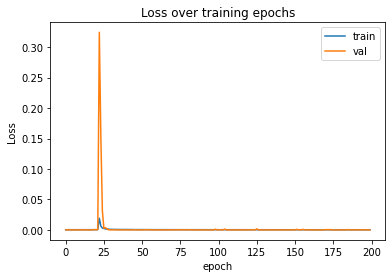

In [73]:
plt.plot(history['train'])
plt.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('Loss over training epochs')
plt.legend(['train','val'])
plt.show()

## 検証

2.9943219715278246e-05


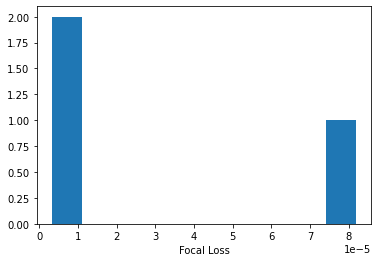

In [83]:
losses = []
with torch.no_grad():
    model = model.eval()
    for x, y, _, sig in test_loader:
        x = model(x)
        loss = criterion(x, y, sig)
        losses.append(loss.item())
        
print(np.mean(losses))
plt.hist(losses)
plt.xlabel('Focal Loss')
plt.show()

0.9999996325952293


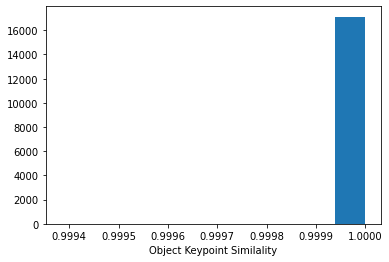

In [106]:
def object_keypoint_similality(pred, gt, bbox):
    d = np.linalg.norm(pred - gt, axis=1)
    wh = bbox[:, 1, :]
    w, h = wh.T
    s = w * h
    
    return np.exp(- d ** 2 / (2 * s ** 2))

oks = []
with torch.no_grad():
    model = model.eval()
    for x, y, bbox, _ in test_loader:
        x = model(x)
        x = x.cpu().numpy()
        y = y.cpu().numpy()
        bbox = bbox.cpu().numpy()
        score = object_keypoint_similality(x, y, bbox)
        oks += score.tolist()
        
print(np.mean(oks))
plt.hist(oks)
plt.xlabel('Object Keypoint Similality')
plt.show()

In [70]:
def draw_keypoints(frame, keypoints, scores=None, vis_th=0.4):
    l_pair = [
        (0, 1), (0, 2), (1, 3), (2, 4),  # Head
        (5, 6), (5, 7), (7, 9), (6, 8), (8, 10),
        (5, 11), (6, 12),  # Body
        (11, 13), (12, 14), (13, 15), (14, 16)
    ]
    p_color = [
        # Nose, LEye, REye, LEar, REar
        (0, 255, 255), (0, 191, 255), (0, 255, 102), (0, 77, 255), (0, 255, 0),
        # LShoulder, RShoulder, LElbow, RElbow, LWrist, RWrist
        (77, 255, 255), (77, 255, 204), (77, 204, 255), (191, 255, 77), (77, 191, 255), (191, 255, 77),
        # LHip, RHip, LKnee, Rknee, LAnkle, RAnkle, Neck
        (204, 77, 255), (77, 255, 204), (191, 77, 255), (77, 255, 191), (127, 77, 255), (77, 255, 127), (0, 255, 255)
    ]
    line_color = [
        (0, 215, 255), (0, 255, 204), (0, 134, 255), (0, 255, 50),
        (77, 255, 222), (77, 196, 255), (77, 135, 255), (191, 255, 77), (77, 255, 77),
        (77, 222, 255), (255, 156, 127),
        (0, 127, 255), (255, 127, 77), (0, 77, 255), (255, 77, 36)
    ]

    img = frame.copy()
    part_line = {}
    # Draw keypoints
    for n in range(len(keypoints)):
        if scores is not None and scores[n] <= vis_th:
            continue
        cor_x, cor_y = int(keypoints[n, 0]), int(keypoints[n, 1])
        part_line[n] = (cor_x, cor_y)
        cv2.circle(img, (cor_x, cor_y), 3, p_color[n], -1)
    # Draw limbs
    for i, (start_p, end_p) in enumerate(l_pair):
        if start_p in part_line and end_p in part_line:
            start_xy = part_line[start_p]
            end_xy = part_line[end_p]
            if scores is not None:
                cv2.line(img, start_xy, end_xy, line_color[i], 2 * int(scores[start_p] + scores[end_p]) + 1)
            else:
                cv2.line(img, start_xy, end_xy, line_color[i], 3)

    return img


def plot_prediction(img, y, color=(50, 200, 50)):
    for pt in y:
        pt = tuple(pt.astype(int))
        img = cv2.circle(img, pt, 10, color, -1)
    return img

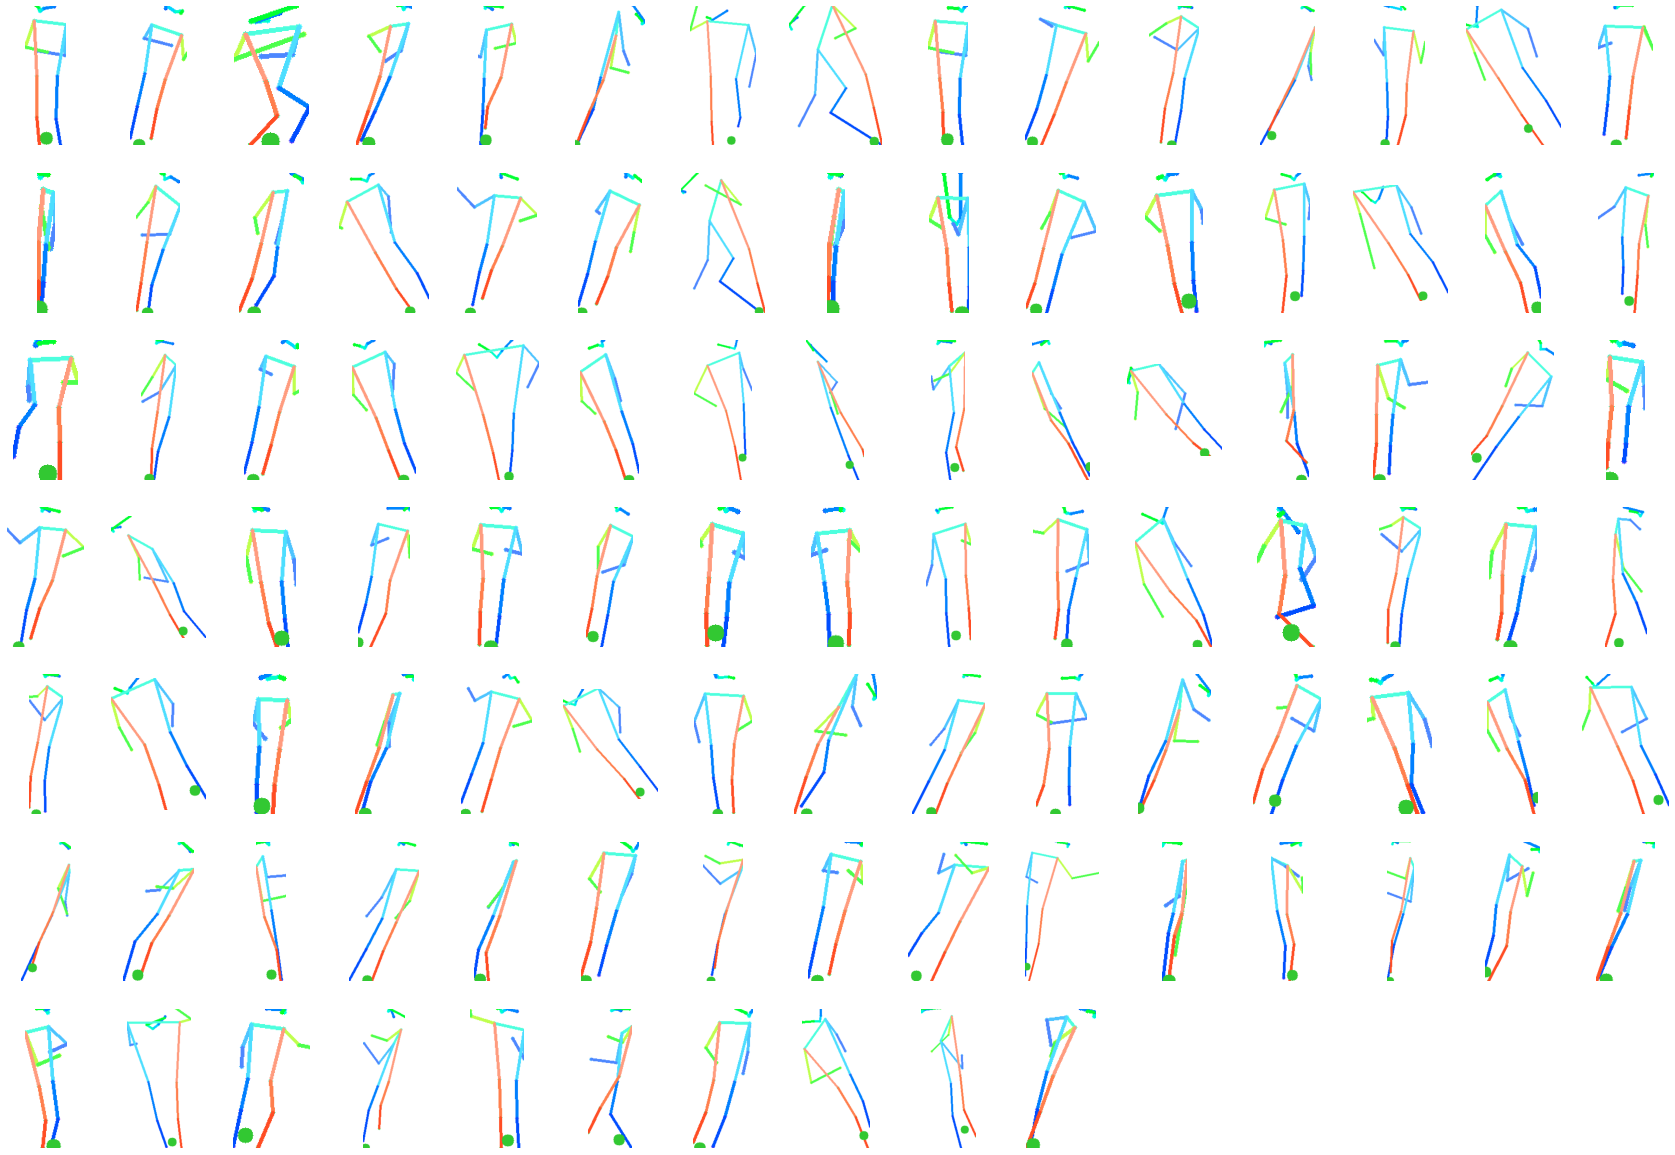

In [76]:
test_len = 100

col_len = 15
row_len = test_len // col_len + 1

model.eval()
with torch.no_grad():
    fig = plt.figure(figsize=(col_len * 2, row_len * 3))
    for i, idx in enumerate(test_idxs[:test_len]):
        kps = keypoints_lst[idx]
        x = [
            kps[body['LShoulder']],
            kps[body['RShoulder']],
            kps[body['LHip']],
            kps[body['RHip']],
        ]
        x = np.array(x).flatten()
        x = tensor([x]).float().to(device)
        y = model(x)
        y = y.cpu().numpy().reshape(-1, 2)
        
        kps = kps
        y = y
        data = kps.tolist() + y.tolist()
        
        mins = np.min(data, axis=0)
        size = (np.max(data, axis=0) - mins).astype(int)
        img = np.ones((size[1], size[0], 3), np.uint8) * 255
        
        img = draw_keypoints(img, kps - mins)
        img = plot_prediction(img, y - mins)
        
        ax = fig.add_subplot(row_len, col_len, i + 1)
        ax.imshow(img)
        ax.axis('off')
        
    plt.show()

In [67]:
path = f'{common.root}/model/checkpoint/keypoints_occlusion.pth'
torch.save(model.state_dict(), path)

with open(f'{common.root}/model/config/keypoints_occlusion.yaml', 'w') as f:
    yaml.dump(net_config, f)